# AQI Prediction Model for  Air Quality Assessment using PySpark

In [1]:
# Importing the necessary libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext
import numpy as numpy
import matplotlib.pyplot as plt 
import seaborn as sns 

from pyspark.sql.functions import *
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LogisticRegression, LinearSVC
from pyspark.ml.regression import LinearRegression, GBTRegressor, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
from sklearn.metrics import confusion_matrix

In [2]:
# Create spark session
spark=SparkSession.builder.appName("App").getOrCreate()

In [3]:
# Loading the data
df1=spark.read.csv("AQIData1.csv",header=True,inferSchema=True)
df2=spark.read.csv("AQIData2.csv",header=True,inferSchema=True)

In [4]:
# showing loaded daat
print(df1.show(5))
print(df2.show(5))

+-------------------+--------+-------------+-------------+--------------+-------------+--------------+----------------+---------------+--------------+---------+------------------+--------------------+------------+
|           datetime|main.aqi|components.co|components.no|components.no2|components.o3|components.so2|components.pm2_5|components.pm10|components.nh3|coord.lon|         coord.lat|extraction_date_time|   city_name|
+-------------------+--------+-------------+-------------+--------------+-------------+--------------+----------------+---------------+--------------+---------+------------------+--------------------+------------+
|2023-11-06 13:22:19|     2.0|       337.12|          0.1|          1.95|        76.53|           1.1|           18.51|          20.02|          2.15| 119.9811|           16.1561|2023-11-06 13:22:...|    Alaminos|
|2023-11-06 13:22:20|     2.0|        343.8|         0.36|          5.01|         60.8|          3.61|            8.12|           9.62|         

In [5]:
# Showing basic information
print(df1.printSchema())
print(df2.printSchema())

root
 |-- datetime: timestamp (nullable = true)
 |-- main.aqi: double (nullable = true)
 |-- components.co: double (nullable = true)
 |-- components.no: double (nullable = true)
 |-- components.no2: double (nullable = true)
 |-- components.o3: double (nullable = true)
 |-- components.so2: double (nullable = true)
 |-- components.pm2_5: double (nullable = true)
 |-- components.pm10: double (nullable = true)
 |-- components.nh3: double (nullable = true)
 |-- coord.lon: double (nullable = true)
 |-- coord.lat: double (nullable = true)
 |-- extraction_date_time: timestamp (nullable = true)
 |-- city_name: string (nullable = true)

None
root
 |-- datetime: timestamp (nullable = true)
 |-- main.aqi: double (nullable = true)
 |-- components.co: double (nullable = true)
 |-- components.no: double (nullable = true)
 |-- components.no2: double (nullable = true)
 |-- components.o3: double (nullable = true)
 |-- components.so2: double (nullable = true)
 |-- components.pm2_5: double (nullable = tru

In [6]:
# Number of rows
print(df1.count())
print(df2.count())

15584
8275


In [7]:
# Column names
print(df1.columns)
print(df2.columns)

['datetime', 'main.aqi', 'components.co', 'components.no', 'components.no2', 'components.o3', 'components.so2', 'components.pm2_5', 'components.pm10', 'components.nh3', 'coord.lon', 'coord.lat', 'extraction_date_time', 'city_name']
['datetime', 'main.aqi', 'components.co', 'components.no', 'components.no2', 'components.o3', 'components.so2', 'components.pm2_5', 'components.pm10', 'components.nh3', 'coord.lon', 'coord.lat', 'extraction_date_time', 'city_name']


In [8]:
# Combining two datasets
df = df1.union(df2)

df.count()

23859

In [9]:
# Datatypes of columns
df.dtypes

[('datetime', 'timestamp'),
 ('main.aqi', 'double'),
 ('components.co', 'double'),
 ('components.no', 'double'),
 ('components.no2', 'double'),
 ('components.o3', 'double'),
 ('components.so2', 'double'),
 ('components.pm2_5', 'double'),
 ('components.pm10', 'double'),
 ('components.nh3', 'double'),
 ('coord.lon', 'double'),
 ('coord.lat', 'double'),
 ('extraction_date_time', 'timestamp'),
 ('city_name', 'string')]

In [10]:
# Changing column names
c=['main.aqi', 'components.co', 'components.no', 'components.no2', 
   'components.o3', 'components.so2', 'components.pm2_5', 
   'components.pm10', 'components.nh3', 'coord.lon', 'coord.lat']
cl=['main_aqi', 'components_co', 'components_no', 'components_no2', 
   'components_o3', 'components_so2', 'components_pm2_5', 
   'components_pm10', 'components_nh3', 'coord_lon', 'coord_lat']

for i,j in zip(c,cl):
    df = df.withColumnRenamed(i, j)
    
df.columns

['datetime',
 'main_aqi',
 'components_co',
 'components_no',
 'components_no2',
 'components_o3',
 'components_so2',
 'components_pm2_5',
 'components_pm10',
 'components_nh3',
 'coord_lon',
 'coord_lat',
 'extraction_date_time',
 'city_name']

In [11]:
# Statistical insights
df.describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+--------------+
|summary|          main_aqi|     components_co|     components_no|   components_no2|     components_o3|   components_so2| components_pm2_5|  components_pm10|    components_nh3|         coord_lon|         coord_lat|     city_name|
+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+--------------+
|  count|             23859|             23859|             23859|            23859|             23859|            23859|            23859|            23859|             23859|             23859|             23859|         23859|
|   mean| 1.577014962907079|366.15860597678585| 0.528073682886978|6.066930298839

In [12]:
# Checking for missing values
c=['datetime','main_aqi','components_co','components_no','components_no2',
   'components_o3','components_so2','components_pm2_5','components_pm10',
   'components_nh3','coord_lon','coord_lat','extraction_date_time','city_name']

for i in c:
    print(i, df.filter(col(i).isNull()).count())

datetime 0
main_aqi 0
components_co 0
components_no 0
components_no2 0
components_o3 0
components_so2 0
components_pm2_5 0
components_pm10 0
components_nh3 0
coord_lon 0
coord_lat 0
extraction_date_time 0
city_name 0


In [13]:
# There is no missing values

In [14]:
# Checking for duplicated rows
print(df.count()-df.dropDuplicates().count())

0


In [15]:
# There is no duplicated rows

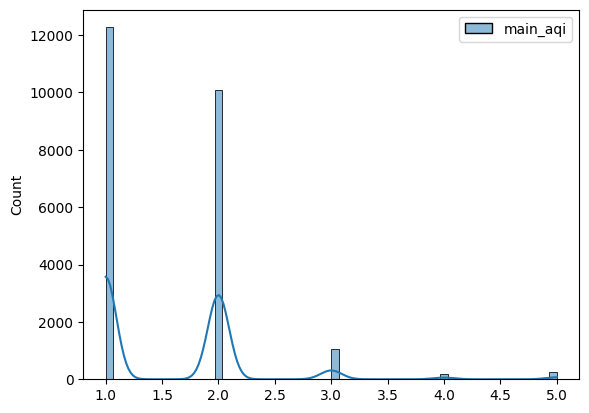

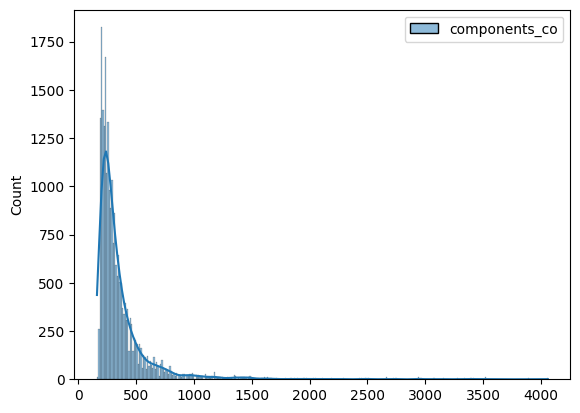

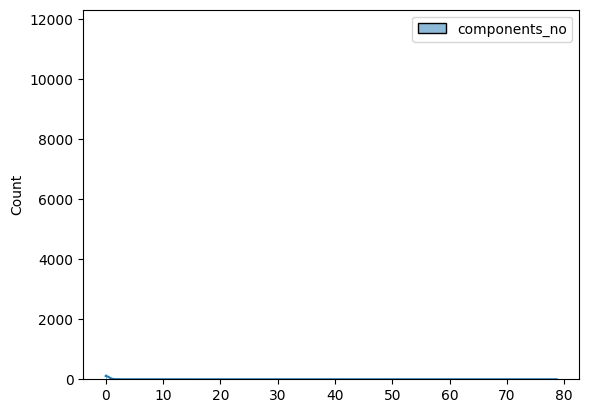

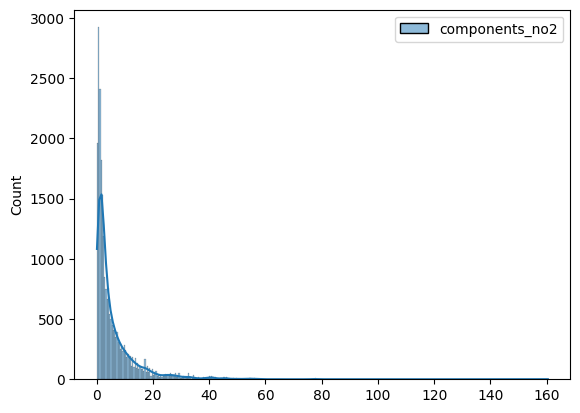

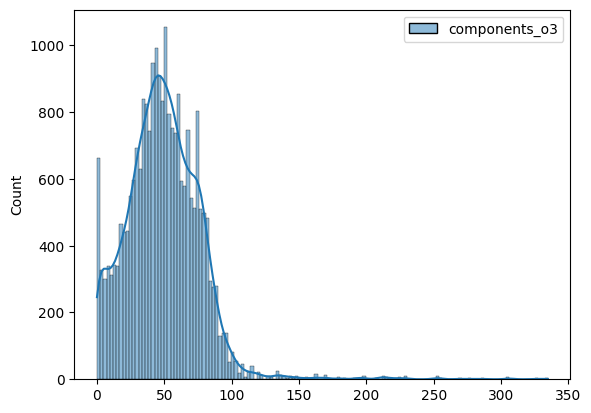

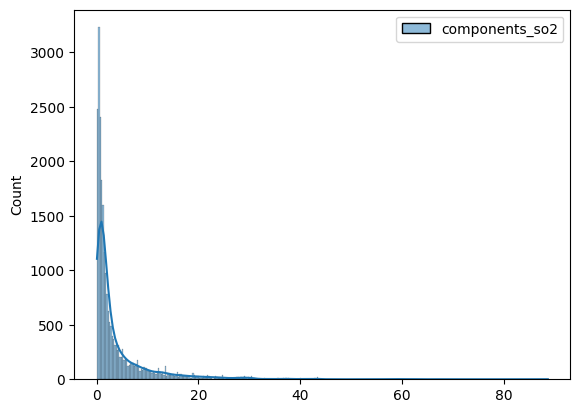

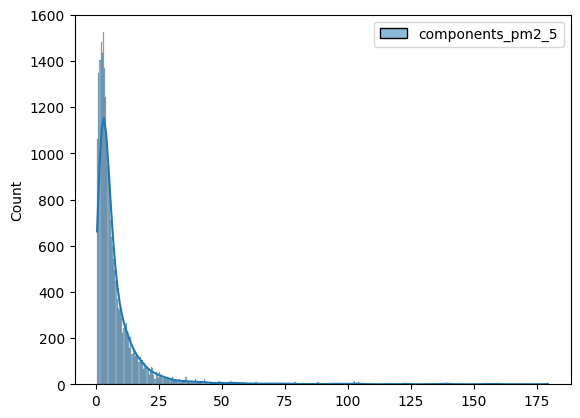

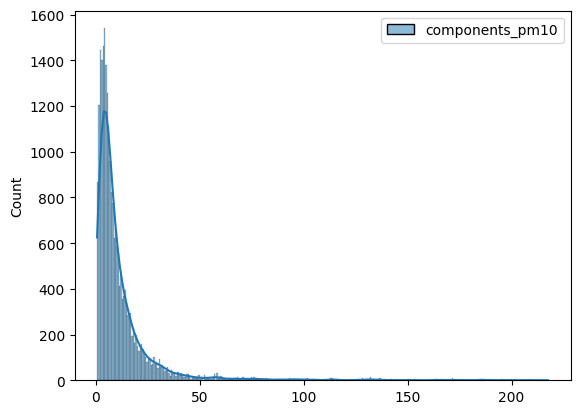

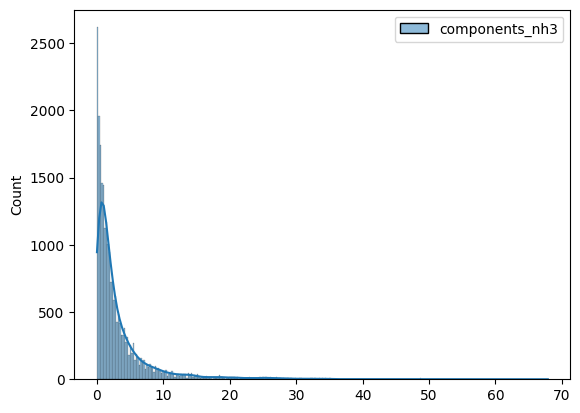

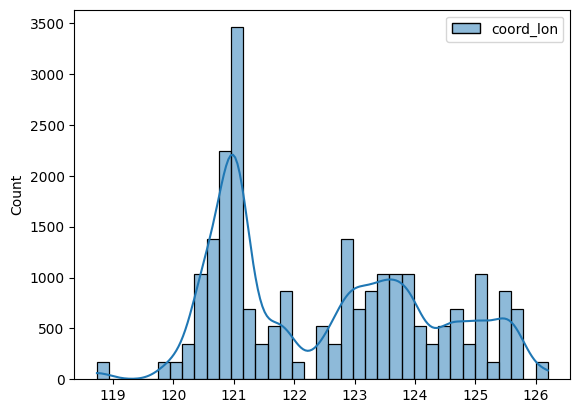

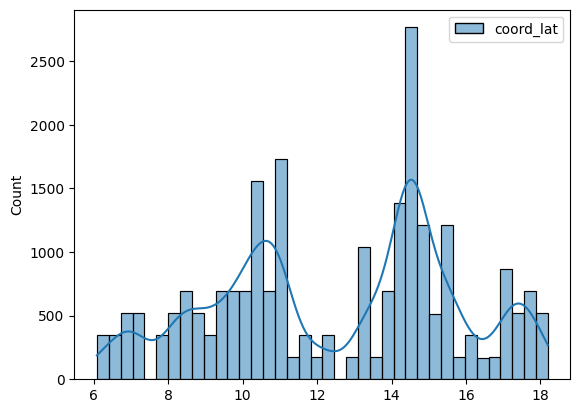

In [16]:
# Showing distribution of data in each column
cl=['main_aqi', 'components_co', 'components_no', 'components_no2', 
   'components_o3', 'components_so2', 'components_pm2_5', 
   'components_pm10', 'components_nh3', 'coord_lon', 'coord_lat']

for i in cl:
    sns.histplot(df.select(i).toPandas(),kde=True)
    plt.show()

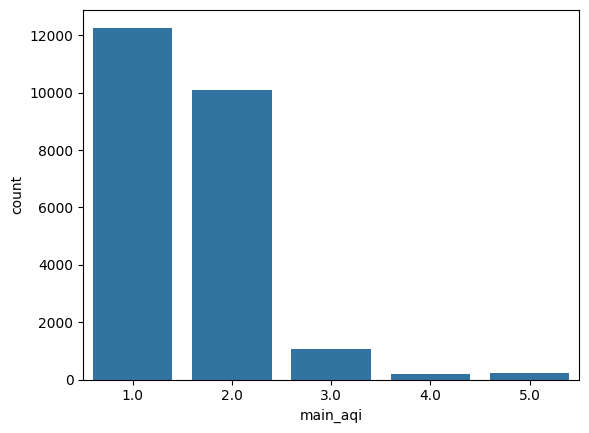

In [17]:
# Count plot for main_aqi column
sns.countplot(data=df.toPandas(),x='main_aqi')
plt.show()

C:\Users\riyag\AppData\Local\Temp\ipykernel_10640\466143299.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.toPandas().corr(),annot=True,cmap='coolwarm')


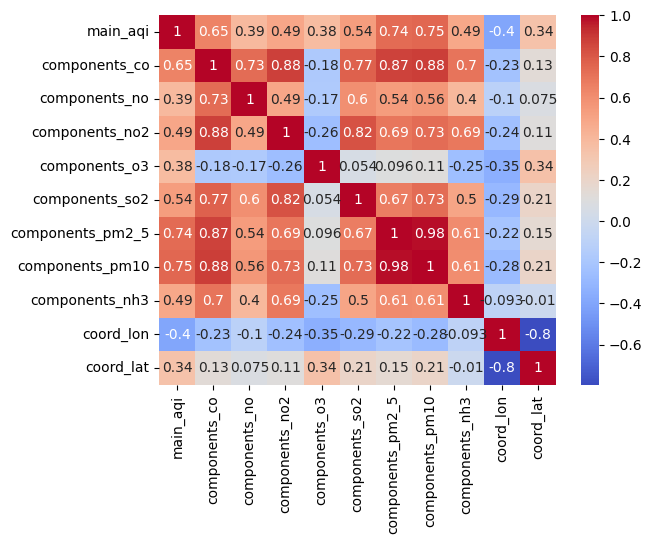

In [18]:
# Correlation heatmap
sns.heatmap(df.toPandas().corr(),annot=True,cmap='coolwarm')
plt.show()

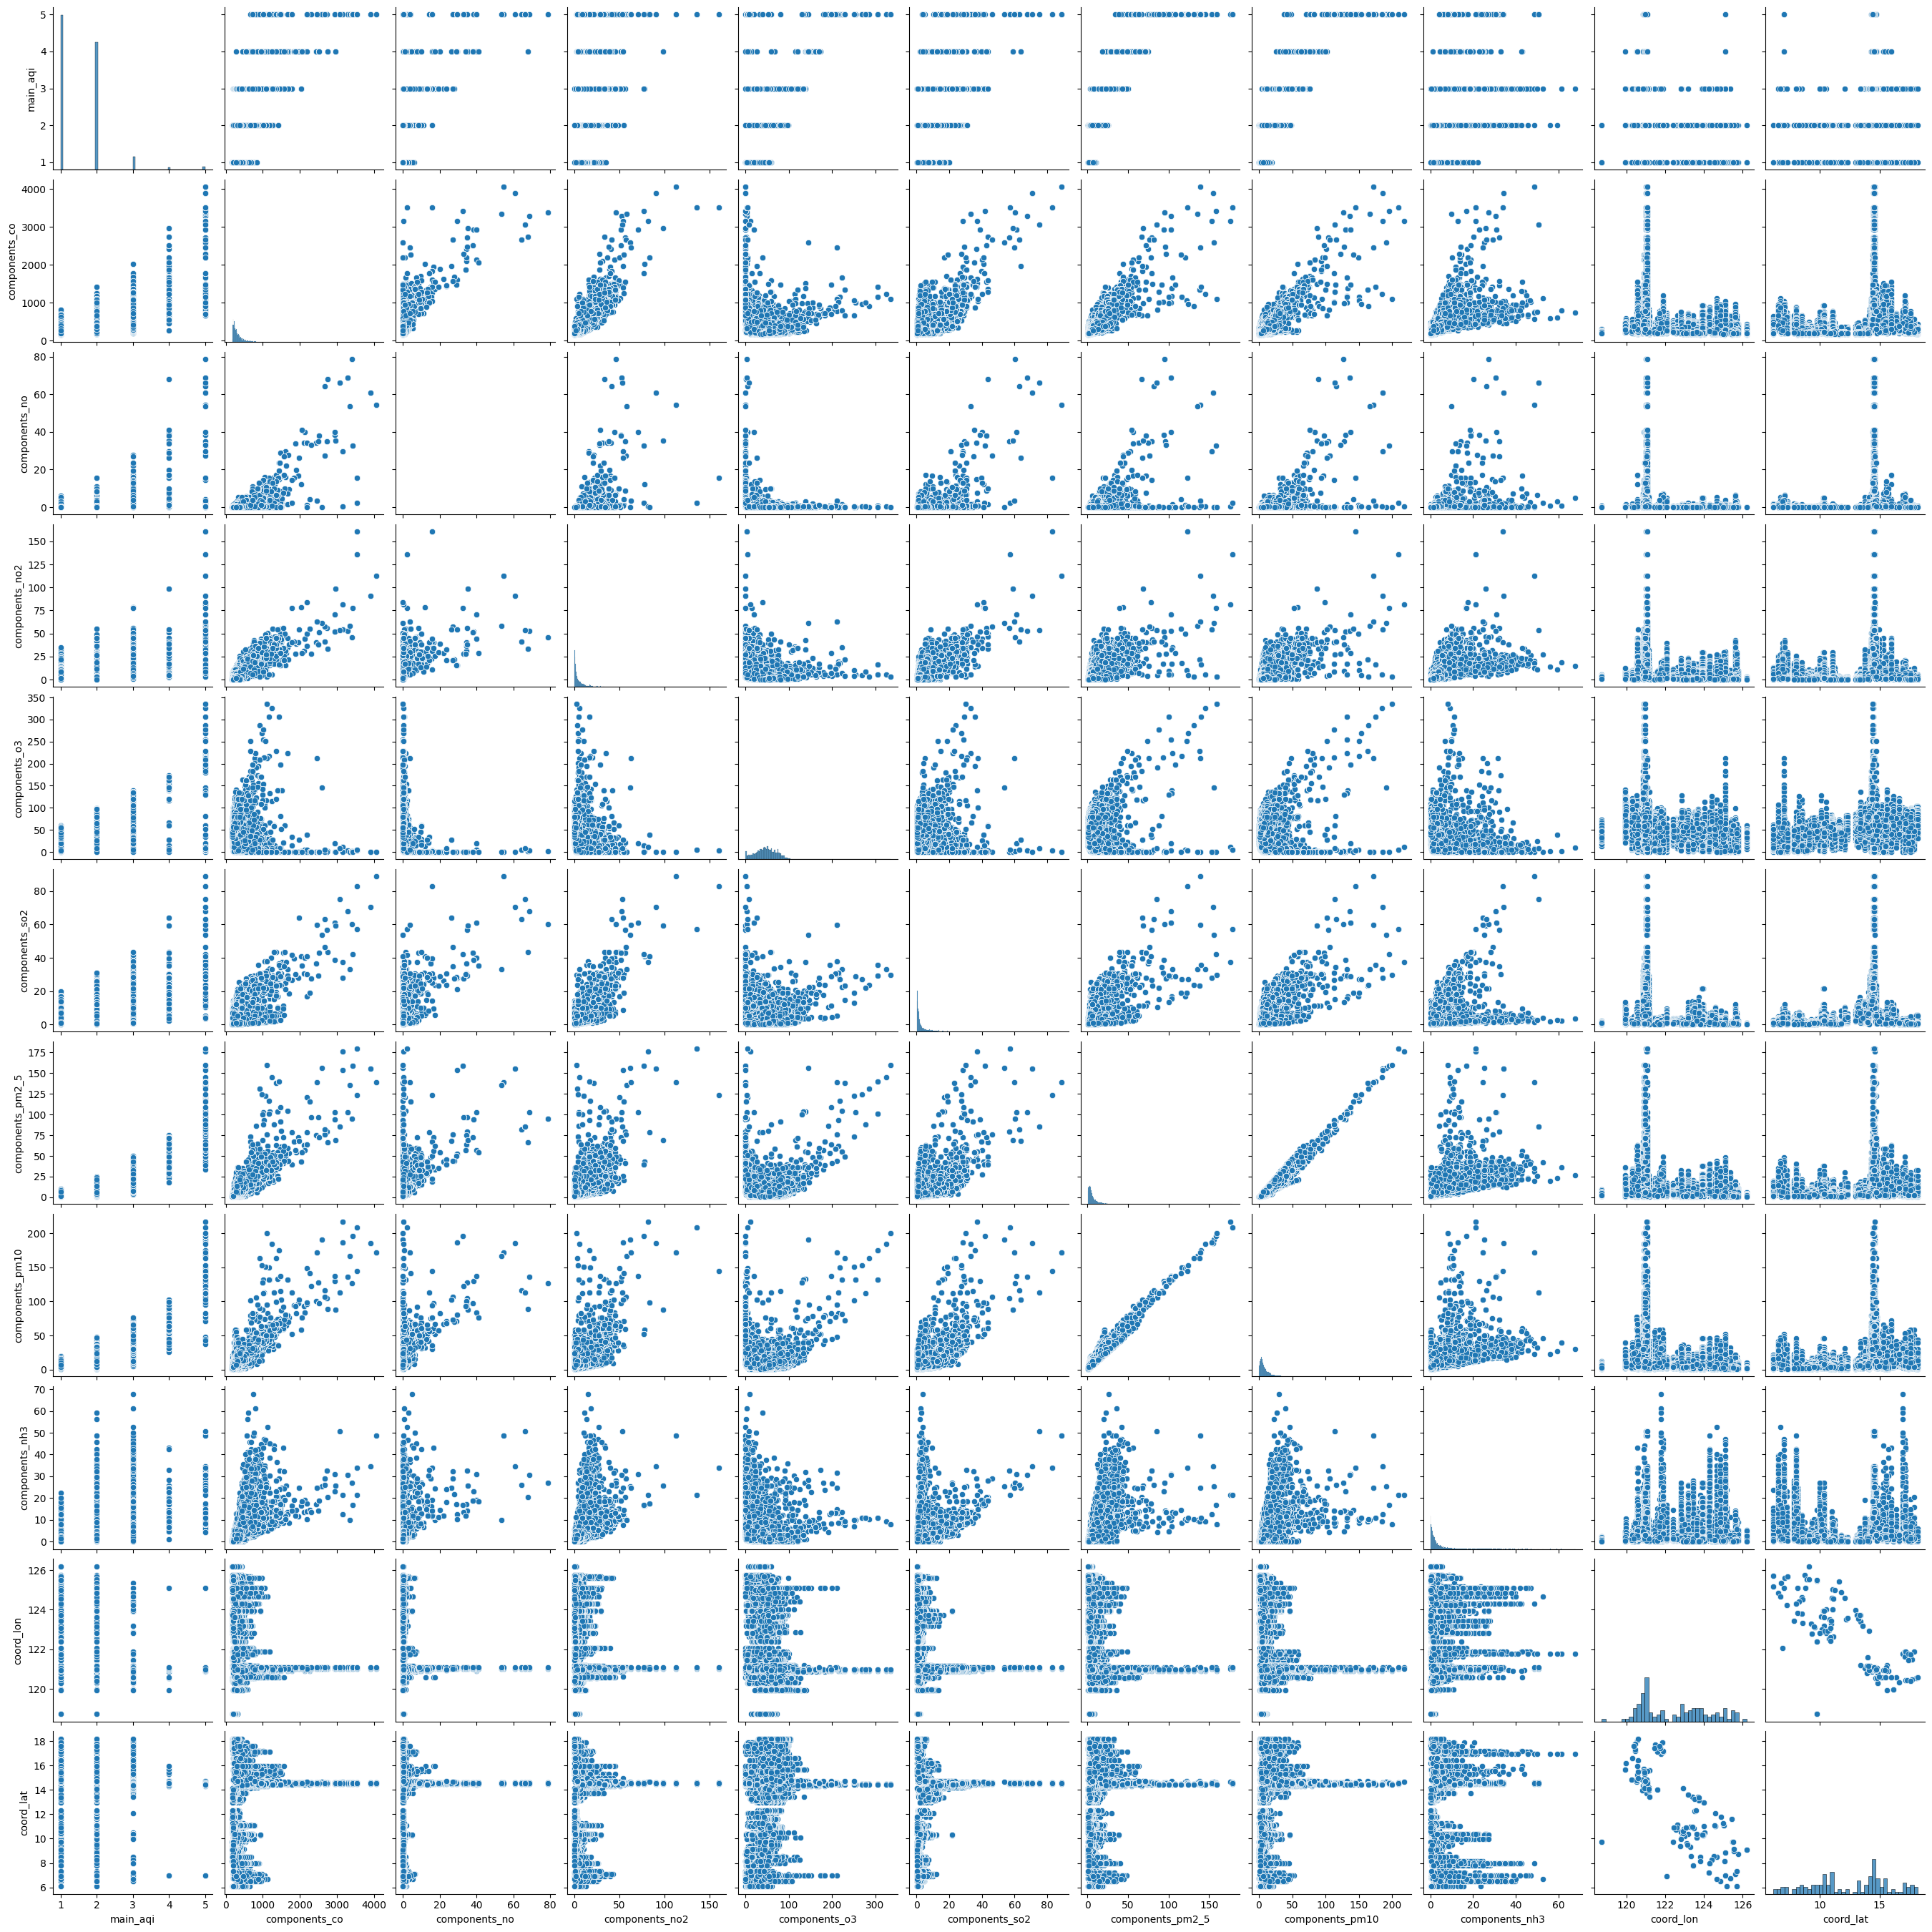

In [19]:
# Pairplot
sns.pairplot(df.toPandas())
plt.show()

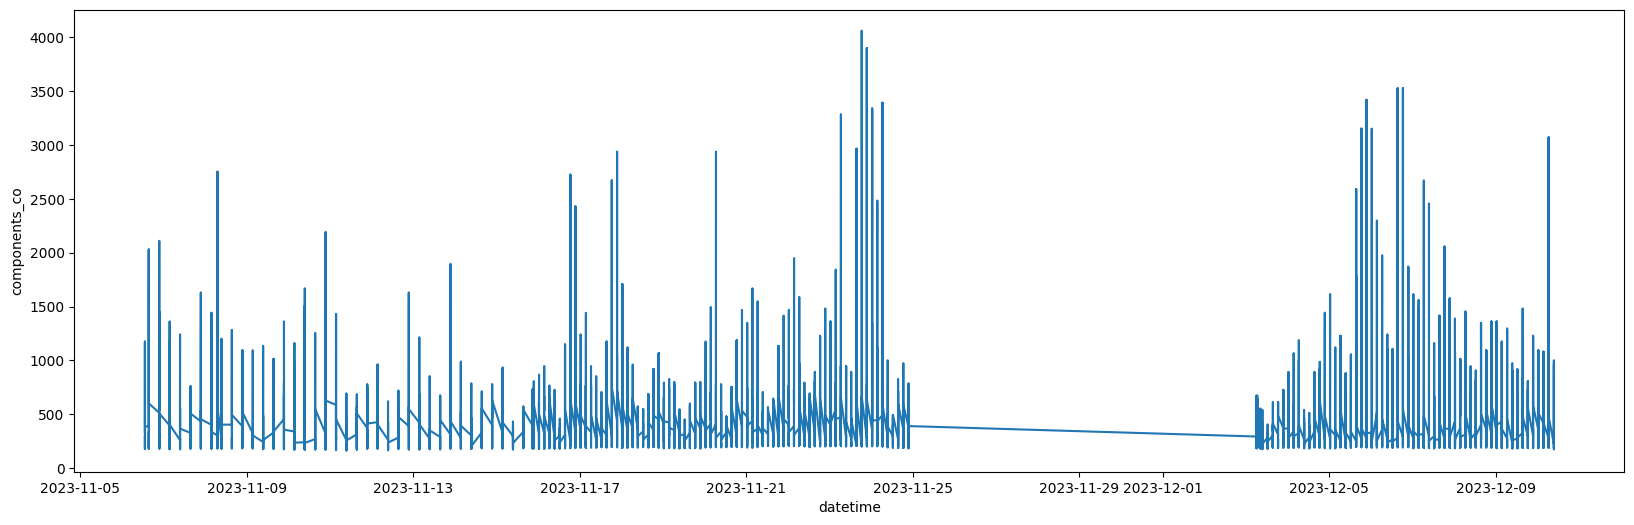

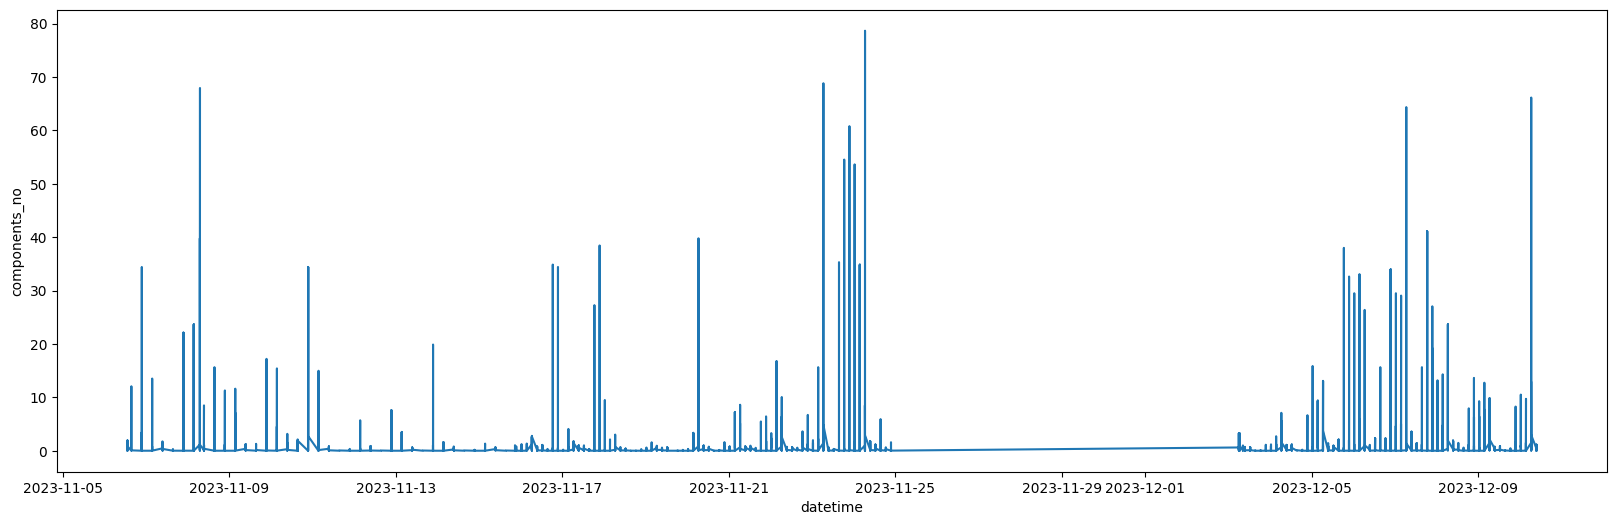

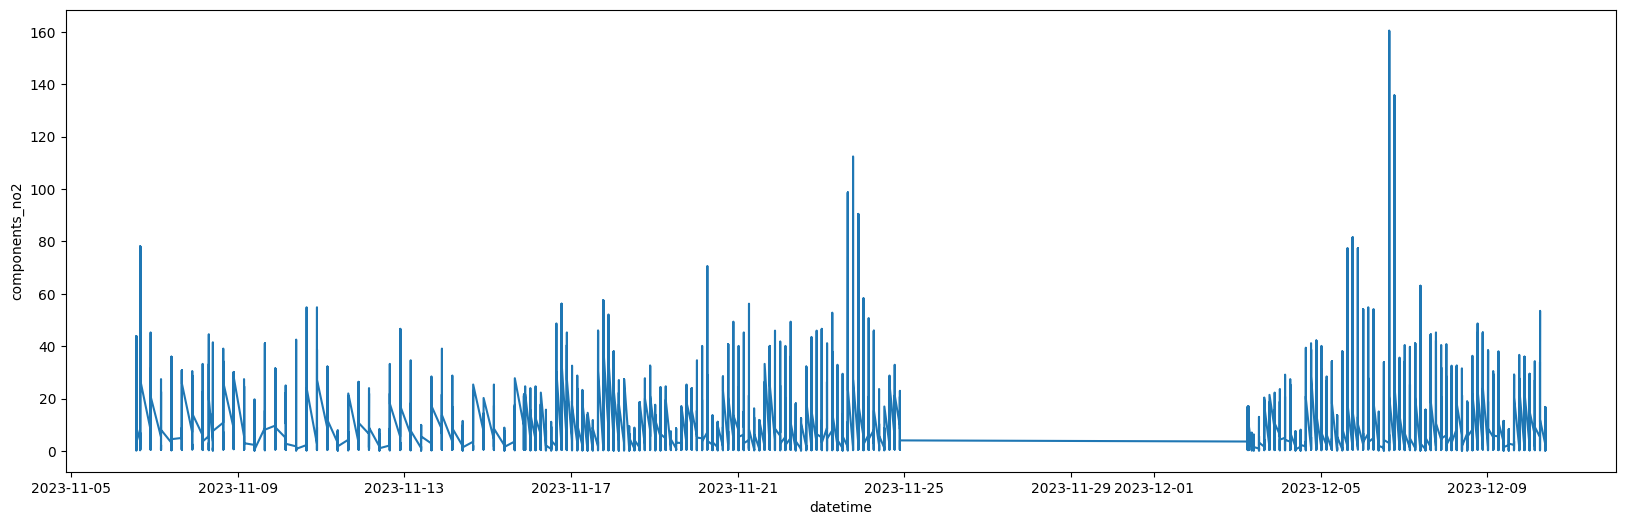

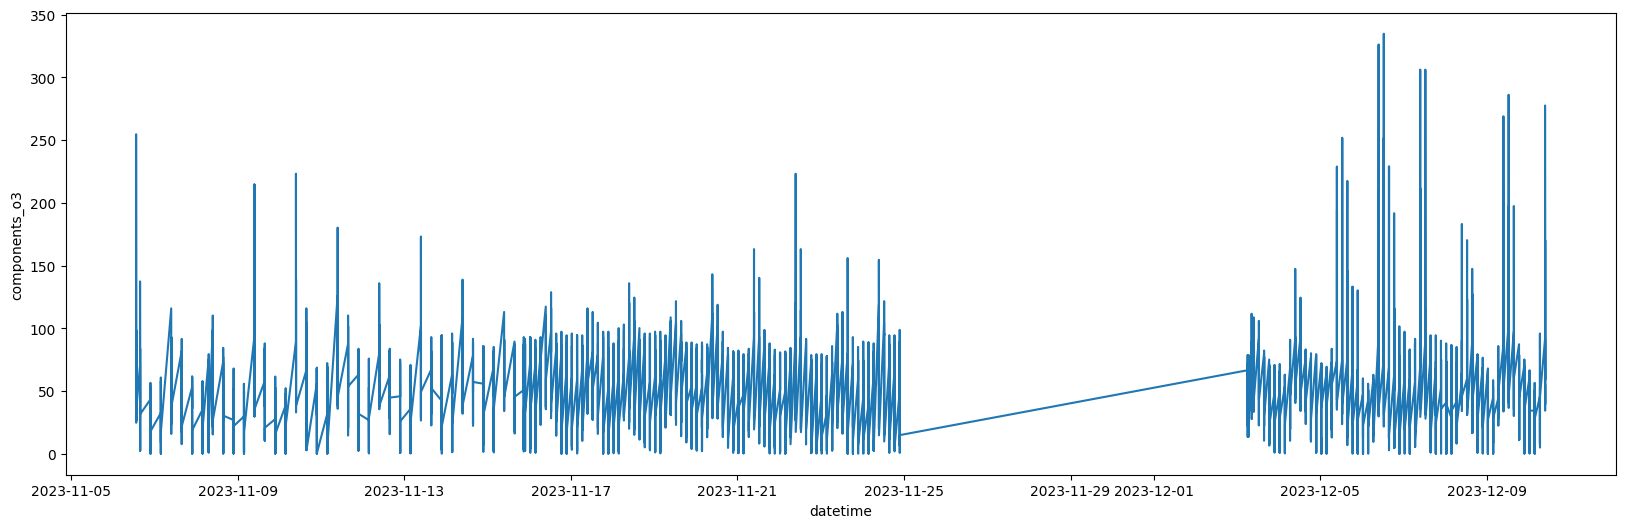

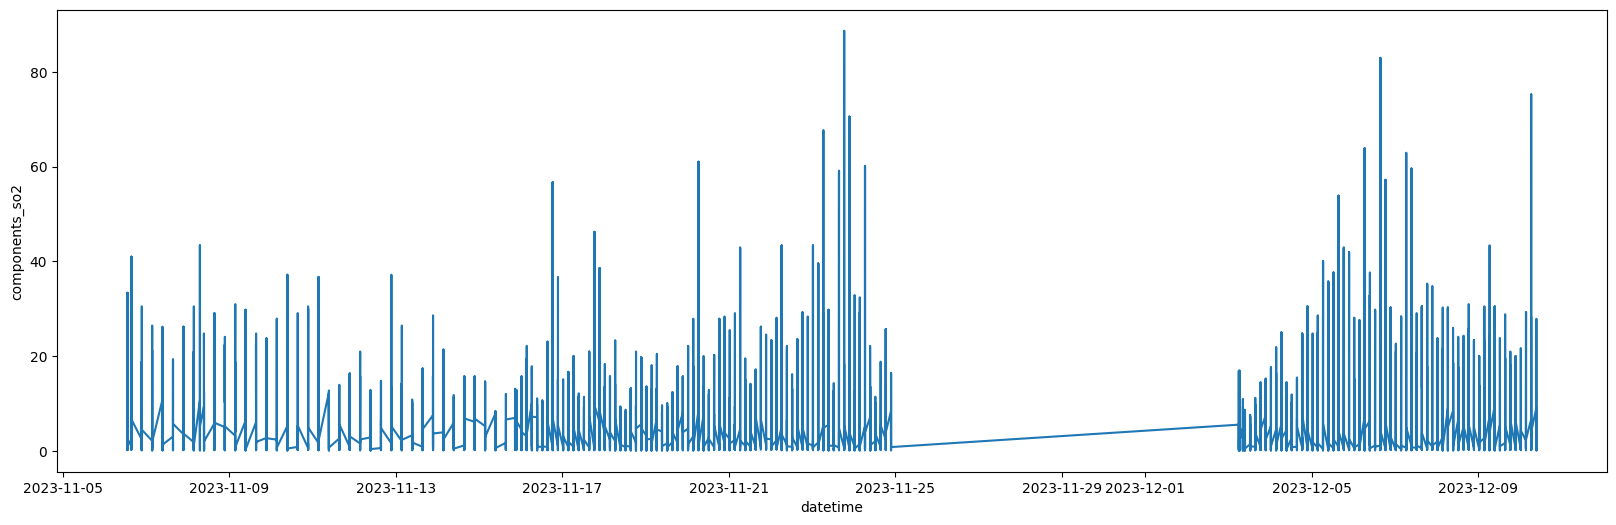

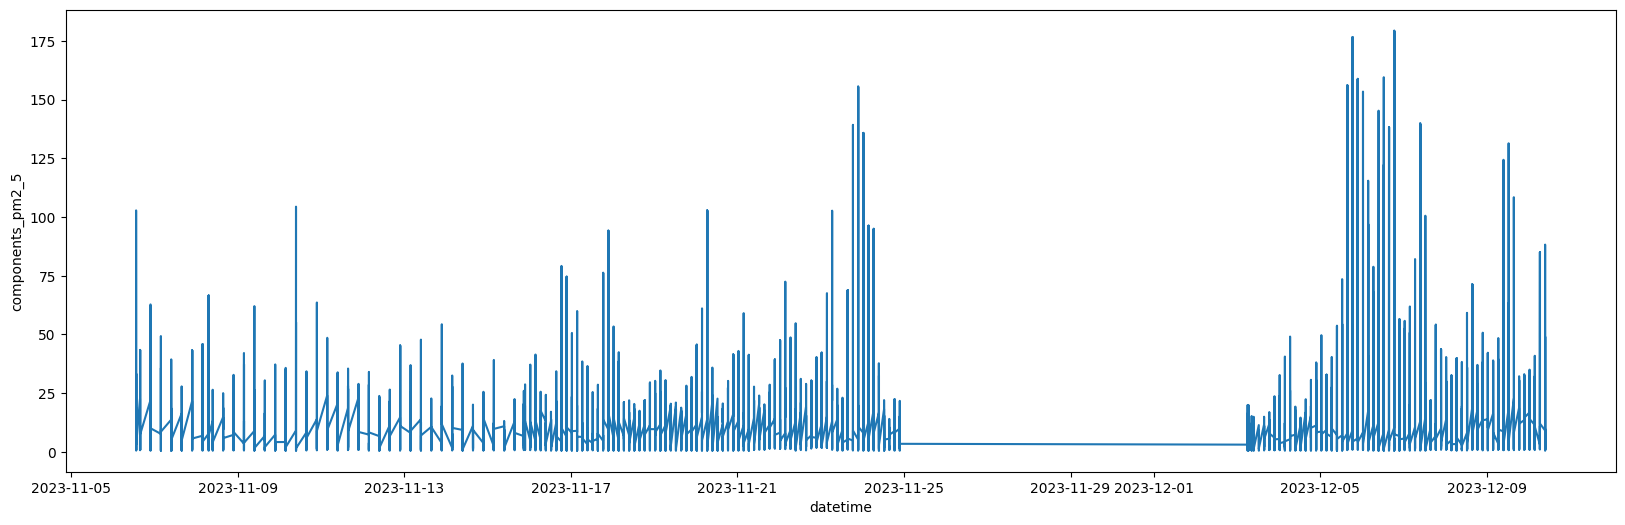

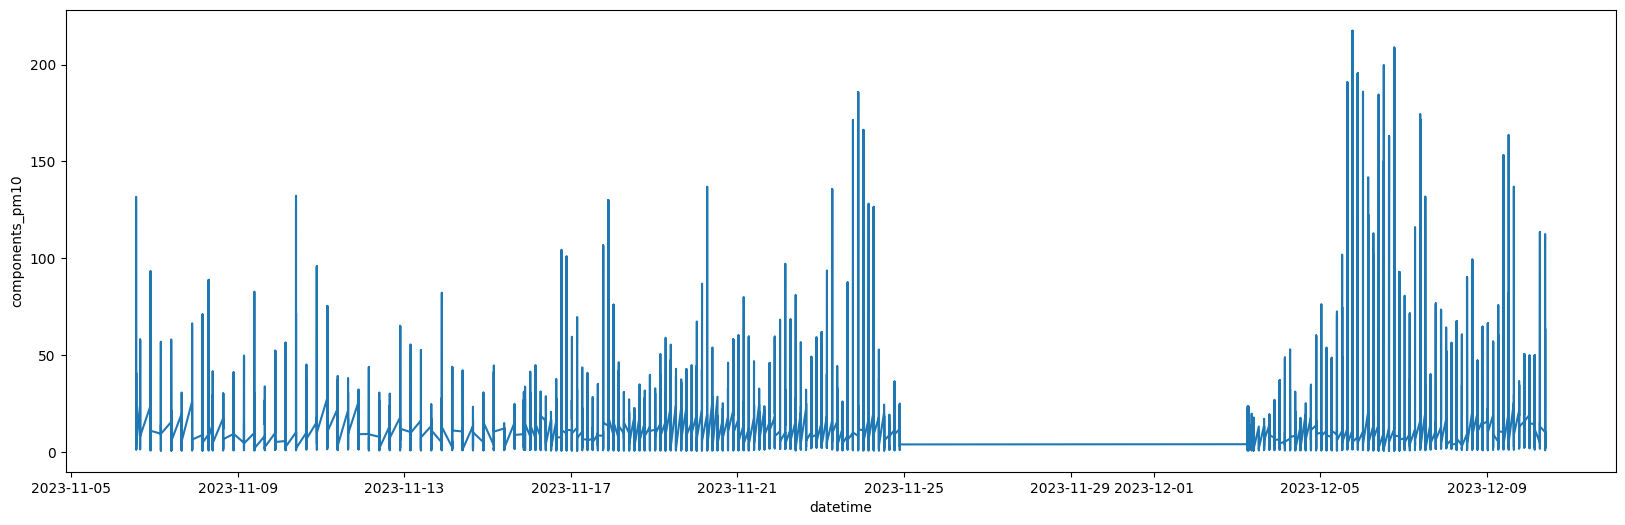

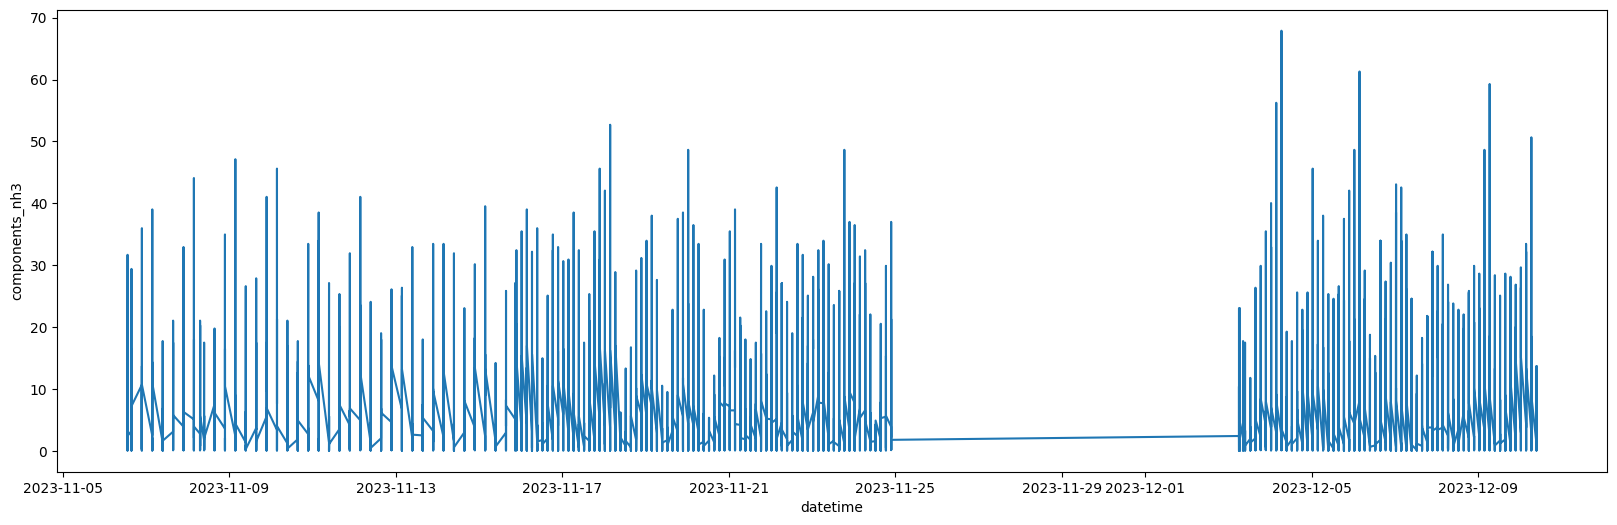

In [20]:
# Showing distribution of columns using lineplot
cl=['components_co', 'components_no', 'components_no2', 
   'components_o3', 'components_so2', 'components_pm2_5', 
   'components_pm10', 'components_nh3']

for i in cl:
    plt.figure(figsize=(20,6))
    sns.lineplot(data=df.toPandas(),y=i,x='datetime')
    plt.show()

In [21]:
# Datatypes of columns
df.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- main_aqi: double (nullable = true)
 |-- components_co: double (nullable = true)
 |-- components_no: double (nullable = true)
 |-- components_no2: double (nullable = true)
 |-- components_o3: double (nullable = true)
 |-- components_so2: double (nullable = true)
 |-- components_pm2_5: double (nullable = true)
 |-- components_pm10: double (nullable = true)
 |-- components_nh3: double (nullable = true)
 |-- coord_lon: double (nullable = true)
 |-- coord_lat: double (nullable = true)
 |-- extraction_date_time: timestamp (nullable = true)
 |-- city_name: string (nullable = true)



In [22]:
# Changing categorical values to numerical

indexer=StringIndexer(inputCol='city_name',outputCol='city_name_label')
df=indexer.fit(df).transform(df)
df.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- main_aqi: double (nullable = true)
 |-- components_co: double (nullable = true)
 |-- components_no: double (nullable = true)
 |-- components_no2: double (nullable = true)
 |-- components_o3: double (nullable = true)
 |-- components_so2: double (nullable = true)
 |-- components_pm2_5: double (nullable = true)
 |-- components_pm10: double (nullable = true)
 |-- components_nh3: double (nullable = true)
 |-- coord_lon: double (nullable = true)
 |-- coord_lat: double (nullable = true)
 |-- extraction_date_time: timestamp (nullable = true)
 |-- city_name: string (nullable = true)
 |-- city_name_label: double (nullable = false)



In [23]:
# Vectorization

vector=VectorAssembler(inputCols=['components_co', 'components_no', 'components_no2', 
   'components_o3', 'components_so2', 'components_pm2_5', 
   'components_pm10', 'components_nh3', 'coord_lon', 'coord_lat','city_name_label'],outputCol='features' )
df_v=vector.transform(df)
df_v.show(3)

+-------------------+--------+-------------+-------------+--------------+-------------+--------------+----------------+---------------+--------------+---------+---------+--------------------+------------+---------------+--------------------+
|           datetime|main_aqi|components_co|components_no|components_no2|components_o3|components_so2|components_pm2_5|components_pm10|components_nh3|coord_lon|coord_lat|extraction_date_time|   city_name|city_name_label|            features|
+-------------------+--------+-------------+-------------+--------------+-------------+--------------+----------------+---------------+--------------+---------+---------+--------------------+------------+---------------+--------------------+
|2023-11-06 13:22:19|     2.0|       337.12|          0.1|          1.95|        76.53|           1.1|           18.51|          20.02|          2.15| 119.9811|  16.1561|2023-11-06 13:22:...|    Alaminos|            0.0|[337.12,0.1,1.95,...|
|2023-11-06 13:22:20|     2.0|  

+-------------------+--------+-------------+-------------+--------------+-------------+--------------+----------------+---------------+--------------+---------+---------+--------------------+----------+---------------+--------------------+------------------+
|           datetime|main_aqi|components_co|components_no|components_no2|components_o3|components_so2|components_pm2_5|components_pm10|components_nh3|coord_lon|coord_lat|extraction_date_time| city_name|city_name_label|            features|        prediction|
+-------------------+--------+-------------+-------------+--------------+-------------+--------------+----------------+---------------+--------------+---------+---------+--------------------+----------+---------------+--------------------+------------------+
|2023-11-06 13:22:22|     1.0|       240.33|          0.1|          1.41|         51.5|          0.41|            1.28|           1.65|           1.2|   121.19|  15.6181|2023-11-06 13:22:...|  Antipolo|          134.0|[240.

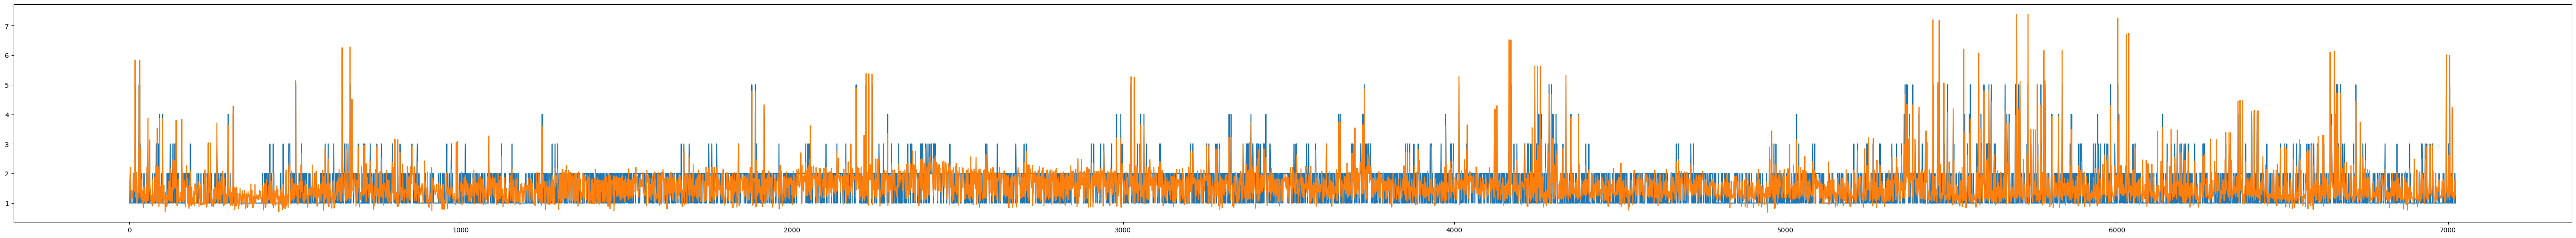

In [24]:
# Machine Learning
# Splitting data. Creating the model. Fitting the model. Evaluation.

train_data,test_data=df_v.randomSplit([0.7,0.3],seed=42)

model=LinearRegression(labelCol='main_aqi',featuresCol='features')
model=model.fit(train_data)
predictions=model.transform(test_data)
print(predictions.show(4))

evaluator=RegressionEvaluator(labelCol='main_aqi',predictionCol='prediction',metricName='rmse')
rmse=evaluator.evaluate(predictions)
print("RMSE: ",rmse)
evaluator=RegressionEvaluator(labelCol='main_aqi',predictionCol='prediction',metricName='r2')
r2=evaluator.evaluate(predictions)
print("R2 Score: ",r2*100)

actual=np.array(predictions.select('main_aqi').collect())
predict=np.array(predictions.select('prediction').collect())
indices=np.arange(1,len(actual)+1)
plt.figure(figsize=(70,6))
plt.plot(indices,actual)
plt.plot(indices,predict)
plt.show()

+-------------------+--------+-------------+-------------+--------------+-------------+--------------+----------------+---------------+--------------+---------+---------+--------------------+----------+---------------+--------------------+------------------+
|           datetime|main_aqi|components_co|components_no|components_no2|components_o3|components_so2|components_pm2_5|components_pm10|components_nh3|coord_lon|coord_lat|extraction_date_time| city_name|city_name_label|            features|        prediction|
+-------------------+--------+-------------+-------------+--------------+-------------+--------------+----------------+---------------+--------------+---------+---------+--------------------+----------+---------------+--------------------+------------------+
|2023-11-06 13:22:22|     1.0|       240.33|          0.1|          1.41|         51.5|          0.41|            1.28|           1.65|           1.2|   121.19|  15.6181|2023-11-06 13:22:...|  Antipolo|          134.0|[240.

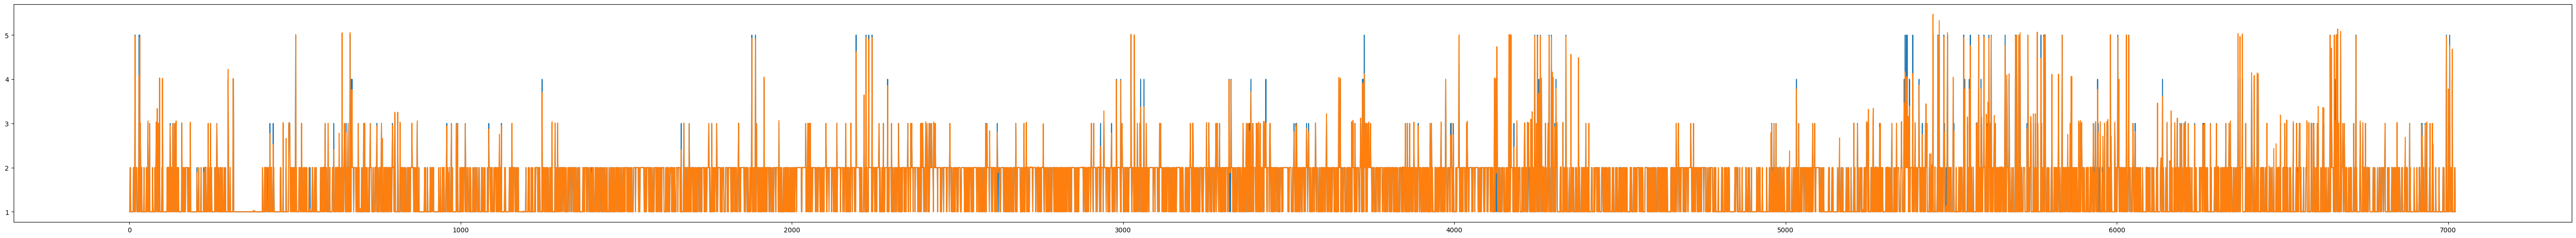

In [25]:
# Machine Learning
# Splitting data. Creating the model. Fitting the model. Evaluation.

train_data,test_data=df_v.randomSplit([0.7,0.3],seed=42)

model=GBTRegressor(labelCol='main_aqi',featuresCol='features',maxBins=150)
model=model.fit(train_data)
predictions=model.transform(test_data)
print(predictions.show(4))

evaluator=RegressionEvaluator(labelCol='main_aqi',predictionCol='prediction',metricName='rmse')
rmse=evaluator.evaluate(predictions)
print("RMSE: ",rmse)
evaluator=RegressionEvaluator(labelCol='main_aqi',predictionCol='prediction',metricName='r2')
r2=evaluator.evaluate(predictions)
print("R2 Score: ",r2*100)

actual=np.array(predictions.select('main_aqi').collect())
predict=np.array(predictions.select('prediction').collect())
indices=np.arange(1,len(actual)+1)
plt.figure(figsize=(70,6))
plt.plot(indices,actual)
plt.plot(indices,predict)
plt.show()

In [27]:
# Both models have good accuracy but last one has best accuracy.